In [1]:
import csv
import utm
proc_click = []
raw = []

path = '../calibrate/rtk-static-test.csv'
with open(path) as clicks:
    reader = csv.reader(clicks)
    for line in reader:
        if line[0] != 'LORA good':
            # print(line)
            if float(line[0]) > 0.0:
                # breakdown line
                u = utm.from_latlon(float(line[0]), float(line[1]))
                # u = pm.geodetic2ned(float(line[0]), float(line[1]), float(line[2]), origin[0], origin[1], origin[2])
                pt = [u[0], u[1]]
                raw.append([float(line[0]), float(line[1])])
                # print(u)
                proc_click.append(pt)

# print(proc_click)

(634, 2)
0.04506268003024161 0.05555625353008509


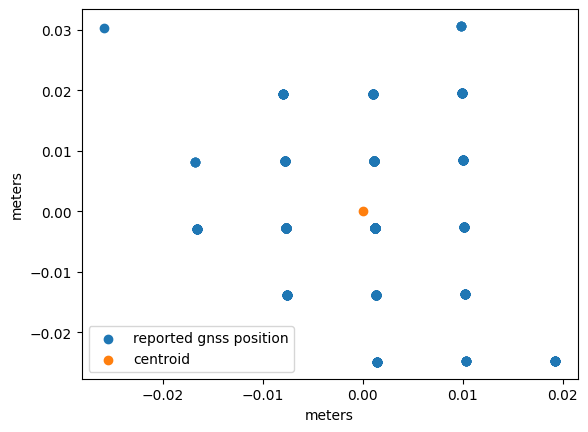

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def reject_outliers(data, m=2):
    return data[abs(data[:,0] - np.mean(data[:,0])) < m * np.std(data[:,0])]

proc_click = [np.asarray(p) for p in proc_click if p[1] > 4.090508e6]

# print(proc_click)
proc_filered = np.asarray(proc_click.copy())
# print(proc_filered)
proc_filered = reject_outliers(proc_filered)


# x = list(list(zip(*proc_click))[0])
# y = list(list(zip(*proc_click))[1])
print(proc_filered.shape)
first = 0
# print(x, y)
center = np.array([np.mean(proc_filered[:,0]), np.mean(proc_filered[:,1])])

proc_filered = proc_filered - center

plt.scatter(proc_filered[:,0], proc_filered[:,1], label='reported gnss position')
plt.scatter(0, 0, label='centroid')
plt.xlabel('meters')
plt.ylabel('meters')
plt.legend(loc='lower left')

x_scale = proc_filered[:,0].max() - proc_filered[:,0].min()
y_scale = proc_filered[:,1].max() - proc_filered[:,1].min()
print(x_scale, y_scale)


<h1>For future refrence</h1><br />
With rtk accuracy std dev<br />
[0.00747523 0.01168309] m (utm)<br />
[1.05333429e-07 8.39099023e-08] deg (lat lon)<br />

without rtk std dev<br />
[0.44530498 0.23433251] m (utm)<br />
[1.71915094e-06 2.40743160e-06] deg (lat lon)<br />

[0.025844942429102957, 0.007929448154754937, 0.007929448154754937, 0.007929448154754937, 0.007929448154754937, 0.007929448154754937, 0.0011926641454920173, 0.0011926641454920173, 0.007819871418178082, 0.007819871418178082, 0.007819871418178082, 0.007819871418178082, 0.007819871418178082, 0.007819871418178082, 0.007710294681601226, 0.007710294681601226, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.009986046119593084, 0.009986046119593084, 0.009986046119593084, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.0009735106723383069, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.001083087408915162, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.0011926641454920173, 0.00119266414549

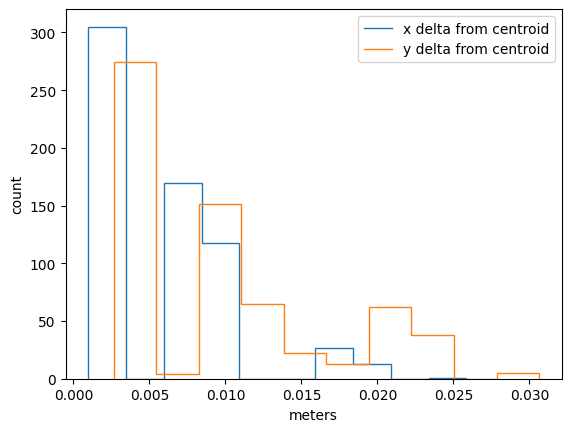

In [3]:
# get deltas from centroid
d_x = abs(proc_filered[:,0])
d_y = abs(proc_filered[:,1])

# filter for deviation of +- 0.05m
d_x = [d for d in d_x if d < 0.05 or d > -0.05]
d_y = [d for d in d_y if d < 0.05 or d > -0.05]

print(d_x)

counts_x, bins_x = np.histogram(d_x)
counts_y, bins_y = np.histogram(d_y)
plt.stairs(counts_x, bins_x, label='x delta from centroid')
plt.stairs(counts_y, bins_y, label='y delta from centroid')
plt.xlabel("meters")
plt.ylabel("count")
plt.legend(loc='upper right')

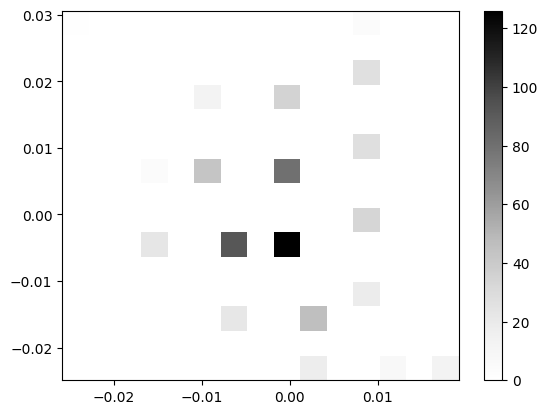

In [4]:
# raw histogram of gps reports
bins = 15
plt.hist2d(proc_filered[:,0], proc_filered[:,1], bins=(bins, bins), cmap=plt.cm.Greys)
plt.colorbar()

In [6]:
# a better plot is showing the distribution of the deviations with respect to the mean,
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets import make_blobs

# Extract x and y
x = proc_filered[:,0]
y = proc_filered[:,1]# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

-0.03035121043212712 0.023724005604162813 -0.0304786067456007 0.0361888974905014


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

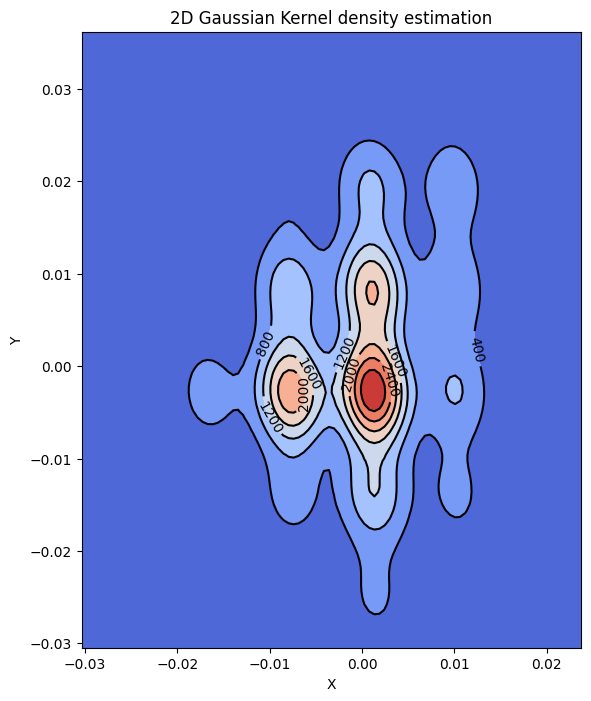

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

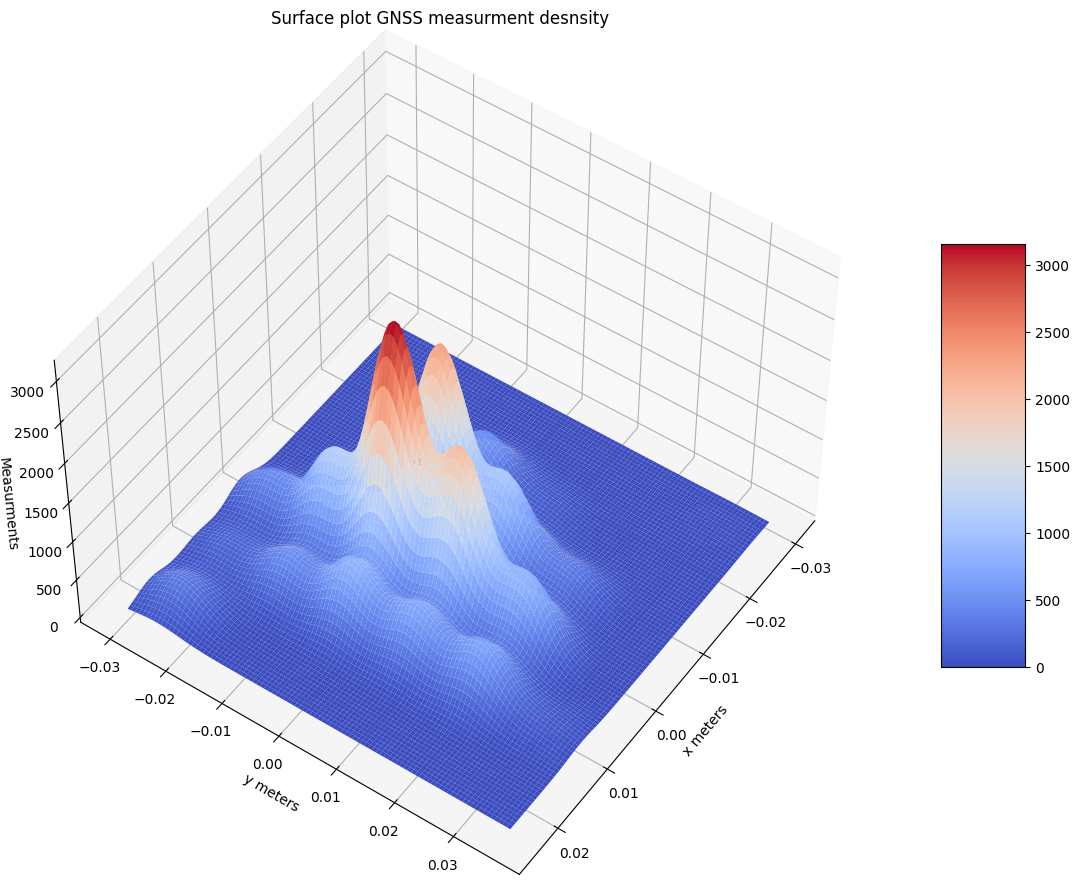

In [23]:
fig = plt.figure(figsize=(20, 11))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x meters')
ax.set_ylabel('y meters')
ax.set_zlabel('Measurments')
ax.set_title('Surface plot GNSS measurment desnsity')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(50, 35)

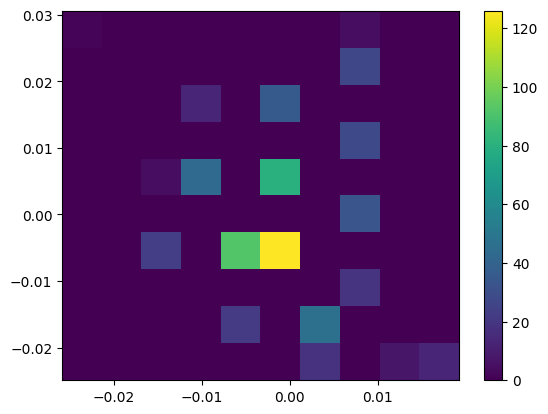

In [9]:
h =plt.hist2d(x, y)
plt.colorbar(h[3])